# Intento 7 - Arquitectura VGG

In [1]:
train_ds_path  ='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set'
test_ds_path   ='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/test_set'
cat_or_dog_path='C:/Users/Usuario/Documents/Master/Aprendizaje Profundo/Udemy/deeplearning-az/datasets/Part 2 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg'

# Parte 1 - Construir el modelo de CNN

# Importar las librerías y paquetes

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import random as rn

"""
Necesitamos la capa de olvido para evitar el sobre-entrenamiento
"""
from keras.layers import Dropout

Fijamos seeds para poder reproducir resultados (aunque aun así a veces no lo conseguimos, probablementa haya inicializaciones que no dependan de estas seeds)

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

# Inicializar la CNN

In [4]:
classifier = Sequential()

# Convolución

### Esta arquitectura apila varias capas convolucionales seguidos de max-pooling. El número de filtros de cada capa aumenta conforme más profunda es la red, doblando el número en cada nivel.

En este intento se apilan varias capas convolucionales seguidas de max-pooling. El número de filtros de cada capa aumenta conforme más profunda es la red, doblando el número en cada nivel. Se añade en cada bloque un dropout para ayudar a reducir overfitting reduciendo la dependencia entre neuronas. Además se usa batch normalization para normalizar cada lote de datos y mejorar el rendimiento de la red.

In [5]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3

# Número de canales de la imagen
Image_Channels = 3

# En este intento añadimos 3 convoluciones, cada una con una normalización, un max pooling y un dropout de 0,25
classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape = (*Image_Size, Image_Channels)))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

# Doblamos el número de filtros
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

# Doblamos el número de filtros
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

# Añadimos dos full-connected layer con 512 unidades y 1 respectivamente; con un dropout de 0,5
classifier.add(Flatten())
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(loss = 'binary_crossentropy',
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

# Parte 2 - Ajustar la CNN a las imágenes para entrenar 

In [6]:
from keras.preprocessing.image import ImageDataGenerator

"""
batch_size=32

32 es el valor por defecto que usaría
model.fit_generator, aunque aquí lo debemos
especificar en los generadores en lugar de
en la llamada al bucle de entrenamiento
"""
batch_size=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(train_ds_path,
                                                     target_size=Image_Size,
                                                     batch_size=batch_size,
                                                     class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(test_ds_path,
                                                   target_size=Image_Size,
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Definimos el callback para hacer early stopping  y realizamos el entrenamiento con las condiciones descritas en la sección de introducción.

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5),
]                                                   

history = classifier.fit(x = training_dataset,
                         steps_per_epoch = 8000 / batch_size,
                         epochs = 100,
                         validation_data = testing_dataset,
                         validation_steps = 2000 / batch_size,
                         workers = 4) # "Si pedimos más de un proceso el rendimiento mejora un poco

Epoch 1/100
250/250 [==============================] - 168s 669ms/step - loss: 0.9507 - accuracy: 0.6004 - val_loss: 0.7378 - val_accuracy: 0.5125
Epoch 2/100
250/250 [==============================] - 166s 664ms/step - loss: 0.6532 - accuracy: 0.6697 - val_loss: 0.6930 - val_accuracy: 0.6260
Epoch 3/100
250/250 [==============================] - 166s 663ms/step - loss: 0.5770 - accuracy: 0.7057 - val_loss: 0.5682 - val_accuracy: 0.7035
Epoch 4/100
250/250 [==============================] - 166s 665ms/step - loss: 0.5353 - accuracy: 0.7275 - val_loss: 0.4795 - val_accuracy: 0.7705
Epoch 5/100
250/250 [==============================] - 167s 666ms/step - loss: 0.4817 - accuracy: 0.7681 - val_loss: 0.7700 - val_accuracy: 0.6030
Epoch 6/100
250/250 [==============================] - 166s 661ms/step - loss: 0.4657 - accuracy: 0.7855 - val_loss: 0.4898 - val_accuracy: 0.7655
Epoch 7/100
250/250 [==============================] - 165s 657ms/step - loss: 0.4435 - accuracy: 0.7884 - val_loss: 0

Pintamos los resultados

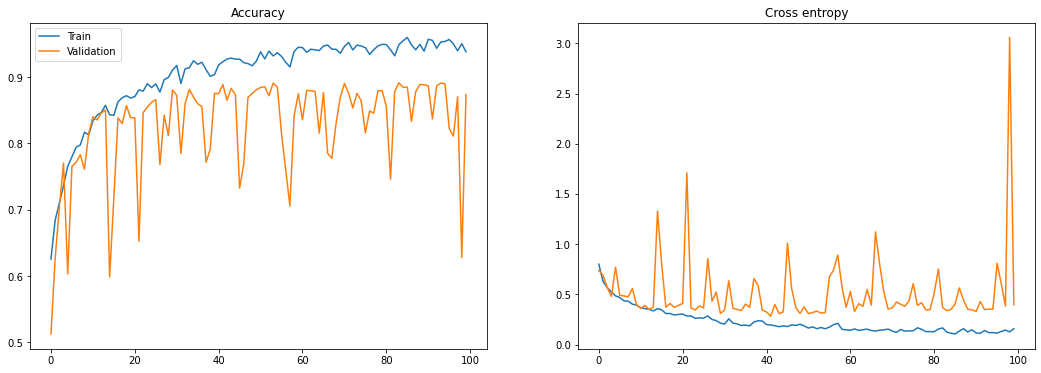

In [8]:
def plot_resultados_training(history):
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].legend()
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Cross entropy')
plot_resultados_training(history)

In [9]:
classifier.save('clasificador5')

INFO:tensorflow:Assets written to: clasificador5\assets


# Parte 3 - Cómo hacer nuevas predicciones

In [10]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(cat_or_dog_path, target_size = Image_Size)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'

print(prediction)


dog
